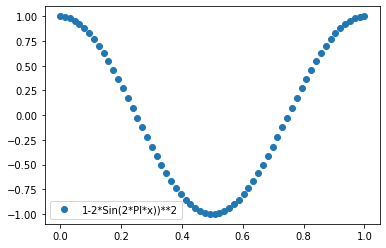

In [1]:
# Parrallelization
import os
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import math
import numpy as np
from numba import jit, cuda, float32 # import jit and cuda provide support for parallelization
import matplotlib.pyplot as plt

@cuda.jit(device = True) # identifies s() as device function to run on GPU
def s(x0):
    return (1.-2.*math.sin(PI*x0)**2)
    # kernal function or "global function" can excute code in parallel on GPU. \
    # Reminder: ___Kernel functions cannot return values, so provide an argument for storing results.___
@cuda.jit # this notation signifies sKernal is global function. Cannot use numpy library in def with @cuda decorator
#@cuda.jit('void(float32[:], float32[:])') # Better notation or 'signature' to specific data type
def sKernel(d_f, d_x):
    i = cuda.grid(1) # This indicates dimentions of computational grid. Replaces for loop
    n = d_x.shape[0] 
    if i < n: # checks bounds to limit calculations
        d_f[i] = s(d_x[i]) # main computation line

# A wrapper of launcher function sArray. Calls for execution of kernal function
def sArray(x):
    n = x.shape[0] #determine number of entries in input array x. Then used to determine size of output and calcuate blocks per grid)
    d_x = cuda.to_device(x) # d_x, d_f are device arrays created since kernal function cannot directly access input. "d_" notation for device array
    d_f = cuda.device_array(n, dtype = np.float32) #need dtype spec for eager compilation
    blockDims = TPB # specifies number of threads in each computation block
    gridDims = (n+TPB-1)//TPB # gridDims specifies number of blocks in computation grid
    sKernel[gridDims, blockDims](d_f, d_x) # new syntax to execute kernal. 
    return d_f.copy_to_host() # return calculated results to host memory

def main():
    x = np.linspace(0, 1, N, dtype=np.float32)
    f = sArray(x)
    plt.plot(x, f, 'o', label='1-2*Sin(2*PI*x))**2')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    N = 64
    PI = np.pi
    TPB = 32 # defines threads per block. Multiple of 32 (size of warp) But really depends on specific hardware
    main()

# Index to identify each iteration
# `blockDim` gives the number of threads in a block.
# `blockIdx` gives the index of a block in the grid.
# `threadIdx` gives the index of a thread in the block.

# Index variable: 1, 2, or 3D. 
# .x , .y, .z : In 1D, y and z are 0
#i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
# or 
#i = cuda.grid(1)

In [ ]:
# Ch 3 Timing
# Simple timing: 
from time import time

start = time() # assign current time to start variable in seconds
variable = map_main() # execute code
end = time() # record time at end point
elapsed = end - start #compute serial runtime
print("--- Timing: %0.4f seconds ---" % elapsed)

# measure multiple times for execution of kernal functions. First measurement always bad

# Synchronous vs Asynchronous execution
# Synchronous: CPU computing. Call one function, it executes, then call next. 
# Asynchronous: Lauch kernal function, GPU executes when able
28:     start = time()
29: 	sKernel[gridDims, blockDims](d_f, d_x)
30: 	end = time()
31: 	elapsed_time = end -  start
32: 	print("--- Kernel time(): %3.4f milliseconds ---" % (1000*elapsed_time))
33: 	return d_f.copy_to_host()
# this will only record time to lauch kernal, not total GPU process time. 

# Cuda event timing
# Using CUDA events, this becomes:
# if return is 0 ms, then means kernal is lauching less than 0 ms
start = cuda.event() #create start event
end = cuda.event()   #create end event
start.record()       #read clock before execution
sKernel[gridDims, blockDims](d_f, d_x) #call for kernel execution
end.record()         #request clock read after execution
end.synchronize()    #make sure execution is complete before reading clock
elapsed = cuda.event_elapsed_time(start, end) #compute interval duration

## See Ch 3 notes for example with parallel_event.property



In [ ]:
# Example of cuda event timing

import os
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import math
import numpy as np
from numba import jit, cuda, float32
from time import time

PI = np.pi
TPB = 32

@cuda.jit(device = True)
def s(x0):
    return (1.-2.*math.sin(PI*x0)**2)

@cuda.jit #Lazy compilation
#@cuda.jit('void(float32[:], float32[:])') #Eager compilation
def sKernel(d_f, d_x):
    i = cuda.grid(1)
    n = d_x.shape[0]	
    if i < n:
        d_f[i] = s(d_x[i]) #content of `for` loop in serial version

def sArray(x):
    n = x.shape[0]
    d_x = cuda.to_device(x)
    d_f = cuda.device_array(n, dtype = np.float32) #need dtype spec for eager compilation
    blockDims = TPB
    gridDims = (n+TPB-1)//TPB

    e_start = cuda.event()
    e_end = cuda.event()
    start = time()
    e_start.record()
    sKernel[gridDims, blockDims](d_f, d_x)
    end = time()
    e_end.record()
    e_end.synchronize()
    event_time = cuda.event_elapsed_time(e_start, e_end)
    elapsed_time = end -  start
    print("--- Kernel time(): %3.4f milliseconds ---" % (1000*elapsed_time))
    print("--- Kernel event: %3.4f milliseconds ---" % (event_time))
    return d_f.copy_to_host()

N = 640000

def main():
    start_all = time() #start overall timer
    x = np.linspace(0, 1, N, endpoint=True)
    start = time() #start timer for serial execution
    f = sArray(x)
    end = time() #stop timer for serial execution
    elapsed_serial = end - start #compute serial runtime
    print("--- Serial timing: %0.4f seconds ---" % elapsed_serial)
    
    for i in range(2):
        start = time() #start timer for parallel execution
        fpar = sArray(x)
        end = time() #stop timer for parallel execution
        elapsed = end - start #compute parallel runtime
        print("--- Parallel timing #%d: %3.4f seconds ---" % (i,elapsed))

    print("--- Loop acceleration estimate: %dx ---" % (elapsed_serial//elapsed))
    end_all = time() #end overall timer
    elapsed = end_all - start_all #evaluate overall runtime
    print("--- Total time: %3.4f seconds ---" % elapsed)
    print("--- Total acceleration estimate: %3.4fx ---" % ((3*elapsed_serial)/(elapsed)))

if __name__ == '__main__':
    main()

In [ ]:
# Debugging
# VS code plug in Nsight
# breakpoints
# numba lets you debug kernal functions using simulation mode
T,B = 2,1 # define thread and block of interest. 
if threadIdx.x == T and blockIdx.x == B:
    breakpoint() # breakpoint at point of interest

#When breakpoint() is called, you can enter terminal commands (terminated by hitting the <Enter> key)

Inspect the value of a variable by entering its name.
Inspect the value of an expression involving variable names.
Step to the next line of execution with s or step or n or next. Step means go to the next line in any function, while next means go to the next line in the current function (so a function called on that line is executed in its entirety rather than line-by-line.)
Continue to the next break point with c.
Continue execution to line #L with j L or jump L.
Print the arguments of a function call with a or args.

# See ch 3 for example

Command	Key	Description
Next	n	Execute next line
Step	s	Step into a subroutine
Print	<v_>	p <v_>	Print value of variable <v_>
<v_>		Print value of variable <v_>
<expr_>		Evaluate and print expression
Return	r	Run until the current subroutine returns
Continue	c	Stop debug; continue execution
Quit	q	Quit pdb

In [28]:
# Ch 4 Evaluating functions on multi-dimensional grids
# CUDA natively supports 3D grids (limitation of cuda)
# geometric grid of two points (xp, yp) and computational 2d grid (i,j) with results of map function
NX, NY = 4 , 4
x = np.linspace(0,1,NX)
y = np.linspace(0,1,NY)

# create tuples of coordinate pairs
X,Y = np.meshgrid(x,y)
# contour plot
plt.contourf(X, Y, f.T) # .T is shorthand for transpose


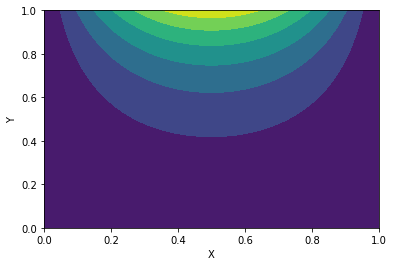

In [41]:
import math
import numpy as np
PI = np.pi
def f2D(x, y):
    return math.sin( PI *x)* math.sinh( PI *y)/ math.sinh( PI )

def fArray2D(x, y):
    nx = x.size
    ny = y.size
    f = np.empty((nx ,ny), dtype = np.float32)

    for i in range(nx):
        for j in range(ny):
            f[i,j] = f2D(x[i], y[j])
    return f

NX, NY = 128, 64 # N = 128

def main():
	x = np.linspace(0, 1, NX) #SAME
	y = np.linspace(0, 1, NY)

	f = fArray2D(x, y) #f = sArray(x)

	X, Y = np.meshgrid(x, y) #plot.plot(x,f,'bo')
	plt.contourf(X, Y, f.T) #`T` is shorthand for `transpose()`
	plt.xlabel("X")
	plt.ylabel("Y")
	plt.show()

if __name__ == '__main__':
	main()

In [2]:
# Parallelization of above function 
# copy to independent .py file to run. 
import os
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import math
import numpy as np
from numba import cuda
PI = np.pi
TPBX = 16 # multiple of 32 up to total of 1024. 32 x 32 is max 512 X 2 is possible
TPBY = 16

#@cuda.jit( device = True ) #  device = True identify as device function
def f2D(x, y):
    return math.sin( PI *x)* math.sinh( PI *y)/ math.sinh( PI )

#@cuda.jit('void (f4[:] , f4[:] , f4[: ,:])') 
# @cuda.jit # identifies the function to be lauched on host and executed on device
# void : this part specifies that function cannot return a value
# the remainder indicates there will be 3 arguments (two 1D arrays f4[:] and a 2D array f4[:,:])
def fKernel2D(d_x , d_y , d_f): # kernal function with 3 arguments
    i , j = cuda.grid(2)
#Note that i,j = cuda.grid(2) is numba's handy abbreviation for the equivalent code: 
#i = threadIdx.x + blockDim.x * blockIdx.x 
#j = threadIdx.y + blockDim.y * blockIdx.y 
    nx , ny = d_f.shape # assign dimensions to array being computed. 
    if i < nx and j < ny:
        d_f[i,j] = f2D(d_x[i], d_y[j])

def fArray2D(x, y):
    nx = x.size
    ny = y.size

    d_x = cuda.to_device(x) # create mirror copies to be used by kernal function
    d_y = cuda.to_device(y)
    d_f = cuda.device_array((nx , ny), dtype = np.float32)

    gridDims = ((nx + TPBX - 1)//TPBX , (ny + TPBY - 1)// TPBY ) # the number of blocks in the grid
    blockDims = (TPBX , TPBY ) # The number of threads in the block

    fKernel2D[ gridDims , blockDims ](d_x , d_y , d_f)
    # return stores d_f on host memory, but does not return anything
    return d_f.copy_to_host()

NX, NY = 128, 64 # N = 128
s
def main():
    x = np.linspace(0, 1, NX) #SAME
    y = np.linspace(0, 1, NY)

    f = fArray2D(x, y) #f = sArray(x)

    X, Y = np.meshgrid(x, y) #plot.plot(x,f,'bo')
    plt.contourf(X, Y, f.T) #`T` is shorthand for `transpose()`
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# For 3D example
TPBX, TPBY, TPBZ = 8, 8, 8

@cuda.jit(device = True)
def f3D(x0, y0, z0):
    return math.sin(np.pi * x0) * math.cos(np.pi * z0) * math.sinh(np.pi * y0) / math.sinh(np.pi)

@cuda.jit
def fKernel3D(d_f, d_x, d_y, d_z):
    i,j,k = cuda.grid(3)
	nx,ny,nz = d_f.shape	
	if i < nx and j < ny and k < nz:
		d_f[i,j,k] = f3D(d_x[i], d_y[j], d_z[k])

def fArray3D(x, y, z):
	nx = x.shape[0]
	ny = y.shape[0]
	nz = z.shape[0]
	d_x = cuda.to_device(x)
	d_y = cuda.to_device(y)
	d_z = cuda.to_device(z)
	d_f = cuda.device_array(shape = [nx,ny,nz], dtype = np.float32)
	gridDims = (nx+TPBX-1)//TPBX, (ny+TPBY-1)//TPBY, (nz+TPBZ-1)//TPBZ
	blockDims = TPBX, TPBY, TPBZ
	fKernel3D[gridDims, blockDims](d_f, d_x, d_y, d_z)

	return d_f.copy_to_host()

In [ ]:
# Ch 5: Stencils and shared memory
# Situations where not all computatinons are thread independent, but instead have local thread interactions
# Stencils or masks
# Finite difference stencils: 
numpy.linsace(0,1,n) # creates array with n equally spaced values
# h is finite distance between two points h = 1/(n-1)
x[i] = x0 + i*h
f[i] = f(x[i])

forwardD[i] = 1/h *(f[i+1] - f[i])
backwardD[i] = 1/h *(f[i] - f[i-1])
centralD[i] = 1/(2*h) *(f[i+1] - f[i-1])

centralD2[i] = (1/h**2)*(f[i-1] - 2*f[i] + f[i+1]) # second difference estimate



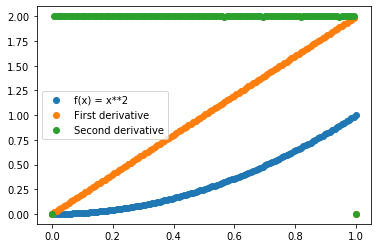

In [3]:
# Example of serial stencil implementatation
# Copy to independent .py file for it to run. 
import numpy as np
import matplotlib.pyplot as plt

N = 128

def p(x0): # defines function p which takes x input and returns x**2 output
    return x0**2

def pArray(x):  # takes x input array and returns array with each value operated on by x**2
    n = x.size
    f = np.empty(n)
    for i in range(n):
        f[i] = p(x[i])
    return f

def nth_deriv(f, order): # takes array of values from above x**2 array and order arguments 
    n = f.shape[0]
    if order == 1:
        stencil = np.array([-1., 0., 1.]) # defines stencil if order is 1 using 1st order central difference
        c = (n-1) / 2.
    elif order == 2:
        stencil = np.array([1., -2nd 1.]) # defines stencil if order is 2 using 3nd order central difference
        c = (n-1)*(n-1)
    deriv = np.zeros(n)

    for i in range(1,n-1): # calculates deriv array depending on order
        deriv[i] = c * (f[i-1]*stencil[0] + f[i] * stencil[1] + f[i+1]*stencil[2])

    # Alternative version of stencil by loop sum
    #RAD = 1
    #for i in range(1,n-1):
    #    for di in range(-RAD, RAD+1):
    #        deriv[i] += f[i+di]*stencil[di+RAD]

    return deriv

def main():
    x = np.linspace(0, 1, N, endpoint=True, dtype=np.float32)
    
    f = pArray(x)
    #print(f)
    plt.plot(x, f, 'o', label='f(x) = x**2')

    dfdx = nth_deriv(f, 1)
    #print(dfdx)
    plt.plot(x, dfdx, 'o', label='First derivative')
    
    d2fdx2 = nth_deriv(f, 2)
    #print(d2fdx2)
    plt.plot(x, d2fdx2, 'o', label='Second derivative')
    
    plt.legend()
    plt.show()

if __name__ == '__main__':
        main()

In [ ]:
# Parallel implementation of stencil app
# copy to independent .py file to run. 
import os
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import numpy as np
from numba import jit, cuda, float32
import matplotlib.pyplot as plt

TPB = 32

@cuda.jit(device = True)
def p(x0):
   return x0**2

@cuda.jit #Lazy compilation
#@cuda.jit('void(float32[:], float32[:])') #Eager compilation
def pKernel(d_f, d_x):
    i = cuda.grid(1)
    n = d_x.shape[0]    
    if i < n:
        d_f[i] = p(d_x[i])

def pArray(x):
    n = x.shape[0]
    d_x = cuda.to_device(x)
    d_f = cuda.device_array(n, dtype = np.float32) #need dtype for eager compile
    pKernel[(n+TPB-1)//TPB, TPB](d_f, d_x)
    return d_f.copy_to_host()
#
@cuda.jit
def df_kernel(d_deriv, d_f, stencil):
    i = cuda.grid(1)
    n = d_f.shape[0]    
    if i > 1 and i < n-1: # test for bounds within stencil radius
        d_deriv[i] = (d_f[i-1]*stencil[0] + d_f[i] * stencil[1] + d_f[i+1]*stencil[2])

def nth_deriv(f, order):
    n = f.shape[0]
    if order == 1:
        stencil =(n-1)/2. * np.array([-1., 0., 1.])
    elif order == 2:
        stencil = (n-1)*(n-1)* np.array([1., -2., 1.])
    d_f = cuda.to_device(f)
    d_deriv = cuda.device_array(n, dtype = np.float32)
    df_kernel[(n+TPB-1)//TPB, TPB](d_deriv, d_f, stencil)

    return d_deriv.copy_to_host()

N = 128

def main():
    x = np.linspace(0, 1, N, endpoint=True, dtype=np.float32)
    f = pArray(x)
    plt.plot(x, f, 'o', label='f(x) = x**2')
    dfdx = nth_deriv(f, 1)
    plt.plot(x, dfdx, 'o', label='First derivative')
    d2fdx2 = nth_deriv(f, 2)
    plt.plot(x, d2fdx2, 'o', label='Second derivative')
    plt.legend()
    plt.show()

if __name__ == '__main__':
        main()

In [ ]:
# Performance considerations

# Global memory
cuda.device_array()
cuda.to_device()

# Shared memory
cuda.shared.array()

1 [-63.5   0.   63.5]
2 [ 16129. -32258.  16129.]


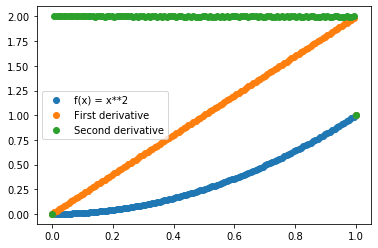

In [1]:
# Shared memory example
# copy to seperate .py file to run
import os
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
import numpy as np
from numba import jit, cuda, float32, int32 # must import data type from numba. Cant use numpy
import matplotlib.pyplot as plt

TPB = 128
#define length of the shared memory array
NSHARED = 130 #value must agree with TPB + 2*RAD Also. This is only addition (from parallel to shared) outside kernal function

@cuda.jit(device = True)
def p(x0):
    return x0**2

@cuda.jit #Lazy compilation
#@cuda.jit('void(float32[:], float32[:])') #Eager compilation
def pKernel(d_f, d_x):
    i = cuda.grid(1)
    n = d_x.shape[0]    
    if i < n:
        d_f[i] = p(d_x[i])

def pArray(x):
    n = x.shape[0]
    d_x = cuda.to_device(x)
    d_f = cuda.device_array(n, dtype = np.float32) #need dtype spec for eager compilation
    pKernel[(n+TPB-1)//TPB, TPB](d_f, d_x)
    return d_f.copy_to_host()

@cuda.jit
#@cuda.jit("void(float32[:],float32[:],float32[:])")
def deriv_kernel(d_deriv, d_f, d_stencil, rad):
    n = d_f.shape[0]
    i = cuda.grid(1)
    sh_f = cuda.shared.array(NSHARED, dtype = float32) # define shared array. Note: dype = float32 and not np.float32 (cany use numpy in kernal function!)
    tIdx = cuda.threadIdx.x #thread index (and index for optional shared output array)
    shIdx = tIdx + rad #index for shared input array

    # use i with d_f, tIdx for threads, and shIdx with sh_f.

    if i>=n:
        return # ends calc if outside bounds

    sh_f[shIdx] = d_f[i] # Load data needed for each thread into shared arrays

    if tIdx < rad: # Load Halo cells- Check that the entries to be loaded are within array bounds
        if i >= rad: # left bounds test
            sh_f[shIdx - rad] = d_f[i-rad] # load left halo cells
        if i + cuda.blockDim.x < n: # right bounds test 
            sh_f[shIdx + cuda.blockDim.x] = d_f[i + cuda.blockDim.x] # load right halo cells

    cuda.syncthreads() #make sure that shared array is fully loaded before any thread reads from it

   #write values only where the full stencil is "in bounds"
    if i >= rad and i < n-rad:
        stencil_dot =  sh_f[shIdx] * d_stencil[rad]
        for d in range(1,rad+1):
            stencil_dot += sh_f[shIdx-d]*d_stencil[rad-d] + sh_f[shIdx+d]*d_stencil[rad+d]
        d_deriv[i] = stencil_dot

def nth_deriv(f, order, rad):
    n = f.shape[0]
    if rad == 1:
        if order == 1:
            stencil =(n-1)/2. * np.array([-1., 0., 1.])
        elif order == 2:
            stencil = (n-1)*(n-1)* np.array([1., -2., 1.])
    elif rad == 2:
        if order == 1:
            stencil =(n-1)/12. * np.array([1., -8., 0., 8., -1.])
        elif order == 2:
            stencil = (n-1)*(n-1)* np.array([-1., 16., -30., 16., -1.])/12.
    print(order, stencil)
    d_f = cuda.to_device(f)
    d_stencil = cuda.to_device(stencil)
    d_deriv = cuda.device_array(n, dtype = np.float32)
    deriv_kernel[(n+TPB-1)//TPB, TPB](d_deriv, d_f, d_stencil, rad)

    return d_deriv.copy_to_host()

N = 128

def main():
    x = np.linspace(0, 1, N, endpoint=True, dtype=np.float32)
    f = pArray(x)
    plt.plot(x, f, 'o', label='f(x) = x**2')
    dfdx = nth_deriv(f, 1,1)
    plt.plot(x, dfdx, 'o', label='First derivative')
    d2fdx2 = nth_deriv(f, 2,1)
    plt.plot(x, d2fdx2, 'o', label='Second derivative')
    plt.legend()
    plt.show()

if __name__ == '__main__':
        main()